**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Nested CV](#2-bullet)
3. [Retrain and Evaluate Model](#3-bullet)

## 1. [Libraries and settings](#1-bullet)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3320 entries, 0 to 3319
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         3320 non-null   float64
 1   High         3320 non-null   float64
 2   Low          3320 non-null   float64
 3   Close        3320 non-null   float64
 4   Volume       3204 non-null   float64
 5   TradingDate  3320 non-null   object 
 6   Code         3320 non-null   object 
dtypes: float64(5), object(2)
memory usage: 207.5+ KB


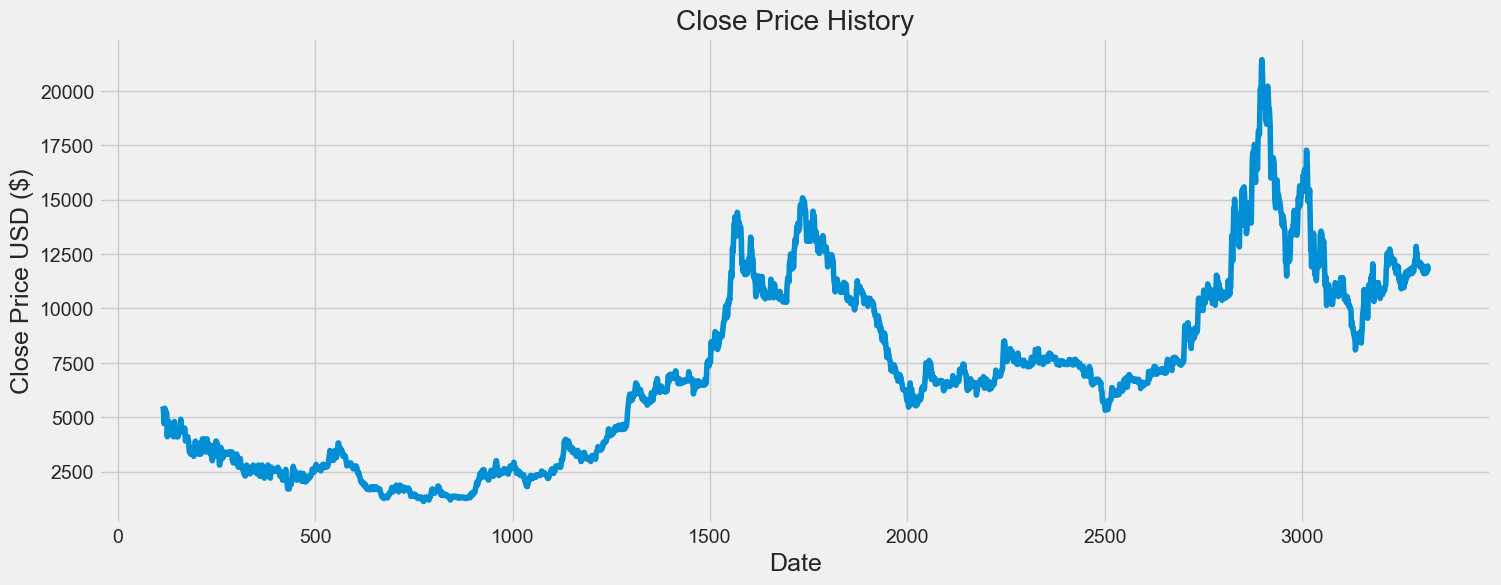

In [1]:
from DataPreprocessing import *

## 2. [Nested CV - Predict Second Half](#2-bullet)

We try to use nested CV for time series to try to tune hyperparameters. After getting best hyperparameters, we retrain model and then evaluate

### Create dataset

In [2]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
time_step = 30
x_for_train, y_for_train = create_dataset(scaled_data, time_step)

x_for_train =x_for_train.reshape(x_for_train.shape[0],x_for_train.shape[1])
y_for_train = y_for_train.reshape(y_for_train.shape[0],1)

### Predict Second Half

In [4]:
def performXGBoost(X_train, Y_train, X_test, Y_test, parameters):

    XGBoost_model = XGBRegressor(n_estimators = parameters['n_estimators'], max_depth = parameters['max_depth'], learning_rate = parameters['learning_rate'])
    XGBoost_model.fit(X_train, Y_train, verbose=False)

    # Make predictions on the test set
    Y_pred_train = XGBoost_model.predict(X_train)
    Y_pred_test = XGBoost_model.predict(X_test)

    # Calculate accuracy
    accuracy_train = r2_score(Y_train, Y_pred_train)
    accuracy_valid = r2_score(Y_test, Y_pred_test)
    
    mse_train = mean_squared_error(Y_train, Y_pred_train)
    mse_valid = mean_squared_error(Y_test, Y_pred_test)
    
    return [accuracy_train, accuracy_valid, mse_train, mse_valid]

In [5]:
def predict_second_half(X, y, params):
    train_size = len(X) // 2
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.5, shuffle=False)
    
    # Assuming you have a validation set stored in variables called 'val_data' and 'val_target'
    # Splitting the training set into training and validation subsets
    X_sub_train, x_val, y_sub_train, y_val = train_test_split(X_train, y_train, test_size=0.5, shuffle=False)
    
    # Training and evaluating the model
    accuracy_train, accuracy_valid, mse_train, mse_valid = performXGBoost(X_sub_train, y_sub_train, x_val, y_val, params)
    
    
    return accuracy_train, accuracy_valid, mse_train, mse_valid



In [6]:
from sklearn.model_selection import ParameterGrid

# Định nghĩa siêu tham số để tinh chỉnh
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3,6,10],
    'learning_rate' : [0.01, 0.05, 0.1]
}

# Chuyển đổi siêu tham số thành danh sách các tham số có thể
param_list = list(ParameterGrid(param_grid))

# Lưu kết quả của các mô hình đã được đánh giá
results = []

# Lặp qua từng bộ tham số để đánh giá mô hình
for i,params in enumerate(param_list):
    print(f"Evaluating parameters {i+1}: {params}")
    
    # Thực hiện Cross Validation với mô hình SVR và siêu tham số tương ứng
    accuracy_train, accuracy_valid, mse_train, mse_valid = predict_second_half(x_for_train, y_for_train, params=params)
    
    # Lưu kết quả vào danh sách
    results.append({
        'parameters': params,
        'accuracy_train': accuracy_train,
        'accuracy_valid': accuracy_valid,
        'mse_train': mse_train,
        'mse_valid': mse_valid
    })

# In kết quả của các mô hình đã đánh giá
for result in results:
    print("Parameters: ", result['parameters'])
    print("Train Accuracy: ", result['accuracy_train'])
    print("Valid Accuracy: ", result['accuracy_valid'])
    print("Train MSE: ", result['mse_train'])
    print("Valid MSE: ", result['mse_valid'])
    print("------------------------")
    
# Sắp xếp danh sách kết quả theo trường 'accuracy_valid' giảm dần
sorted_results = sorted(results, key=lambda x: x['mse_valid'], reverse=False)

# Lấy bộ tham số đầu tiên từ danh sách đã sắp xếp
best_parameters = sorted_results[0]['parameters']

# In ra bộ tham số có accuracy_valid lớn nhất
print("Best Parameters: ", best_parameters)

Evaluating parameters 1: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Evaluating parameters 2: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Evaluating parameters 3: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Evaluating parameters 4: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Evaluating parameters 5: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}
Evaluating parameters 6: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}
Evaluating parameters 7: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}
Evaluating parameters 8: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
Evaluating parameters 9: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}
Evaluating parameters 10: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Evaluating parameters 11: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
Evaluating parameters 12: {'learning_rate': 0.

## 3. [Retrain and Evaluate Model](#3-bullet)

### Create training and testing data

In [7]:
training_size=int(len(dataset)*0.5)
test_size=len(dataset)-training_size
train_data,test_data=scaled_data[0:training_size],scaled_data[training_size:len(dataset)]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1602, 1)
test_data:  (1602, 1)


In [8]:
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1])
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test", y_test.shape)

x_train:  (1571, 30)
y_train:  (1571, 1)
x_test:  (1571, 30)
y_test (1571, 1)


### Building model

Using best hyperparameters after tuning to retrain model

In [9]:
my_model = XGBRegressor(learning_rate = 0.05, n_estimators = 1000, max_depth = 6)
my_model.fit(x_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [10]:
predictions = my_model.predict(x_test)
predictions = predictions.reshape(-1,1)

predictions_train = my_model.predict(x_train)
predictions_train = predictions_train.reshape(-1,1)

In [11]:
predictions = scaler.inverse_transform(predictions)
predictions_train = scaler.inverse_transform(predictions_train)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [12]:
column_names_pred = ['Close_predict']
df_predictions = pd.DataFrame(predictions, columns=column_names_pred)

column_names_test = ['Close_test']
df_test = pd.DataFrame(y_test, columns=column_names_test)

concatenated = np.concatenate([df_predictions, df_test], axis=1)
column_names_concat = ['Close_predict', 'Close_test']
df_concatenated = pd.DataFrame(concatenated, columns = column_names_concat)

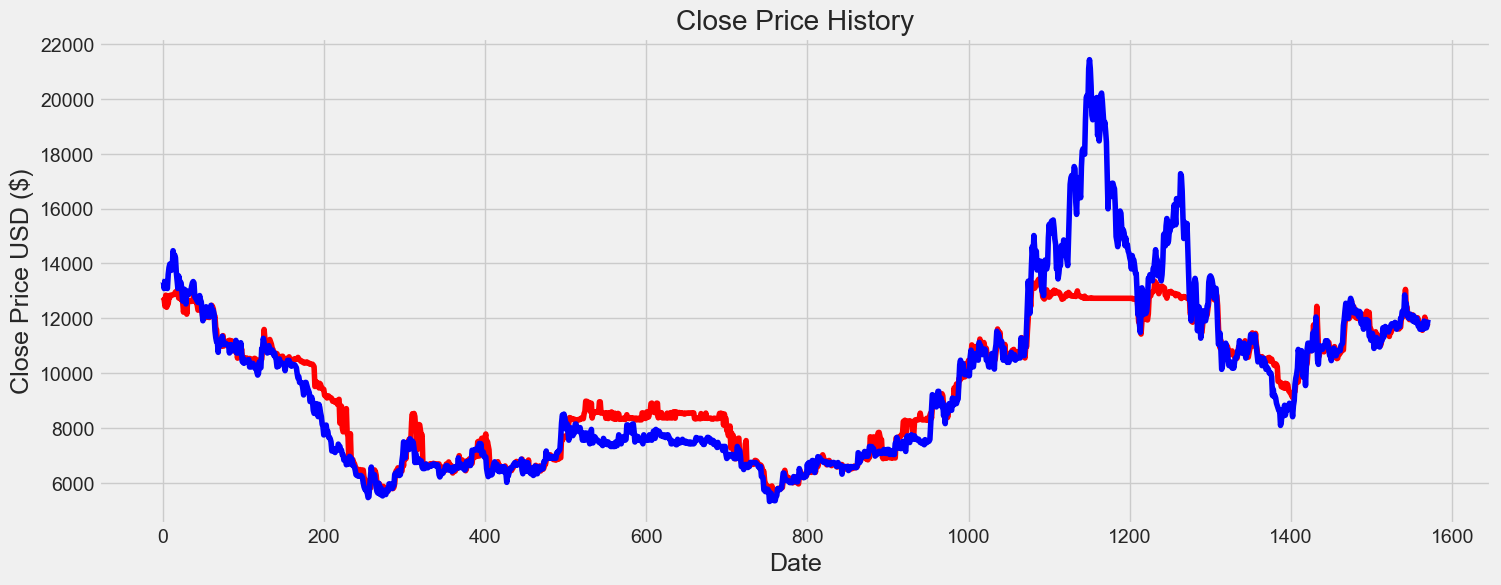

In [13]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df_predictions['Close_predict'], color='red', label='Predicted Close Price')
plt.plot(df_test['Close_test'], color='blue', label='Actual Close Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

### Evaluate model

In [14]:
predictions = scaler.fit_transform(predictions)
predictions_train = scaler.fit_transform(predictions_train)
y_test = scaler.fit_transform(y_test)
y_train = scaler.fit_transform(y_train)

In [15]:

mae_train = mean_absolute_error(y_train, predictions_train)
rmse_train = mean_squared_error(y_train, predictions_train)
accuracy_score_train = r2_score(y_train, predictions_train)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", rmse_train)
print("Train R-squared:", accuracy_score_train)


Train Mean Absolute Error: 0.0019511644196144597
Train Mean Squared Error: 7.282610390252854e-06
Train R-squared: 0.9999927173896097


In [16]:
mae_test = mean_absolute_error(y_test, predictions)
rmse_test = mean_squared_error(y_test, predictions)
accuracy_score_test = r2_score(y_test, predictions)

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", rmse_test)
print("Test R-squared:", accuracy_score_test)

Test Mean Absolute Error: 0.28970585028070817
Test Mean Squared Error: 0.1490171502470017
Test R-squared: 0.8509828497529983
